# Sargassum Density From AFAI

The goal of this notebook is to demonstrate how raw AFAI data is converted into Saragassum density.

In [1]:
using NetCDF
using Dates
using Statistics

In [2]:
using Makie, CairoMakie
include(joinpath(@__DIR__, "..", "..", "CustomMakie.jl", "src", "geo-methods.jl"))
include(joinpath(@__DIR__, "../../CustomMakie.jl/src/statistic-methods.jl"))

axis (generic function with 1 method)

In [3]:
using GeoDatasets
using Interpolations

## Step 0: Data Extraction and Masking

We use the 7-day cumulative AFAI data from [NOAA](https://cwcgom.aoml.noaa.gov/erddap/griddap/noaa_aoml_atlantic_oceanwatch_AFAI_7D.html). Specifically, we start with April 1 2018 - May 1 2018 and choose a stride of 7 days such that there should be four data snapshots which each correspond to one week of April. The netCDF is downloaded from here [click to download (~150 MB)](https://cwcgom.aoml.noaa.gov/erddap/griddap/noaa_aoml_atlantic_oceanwatch_AFAI_7D.nc?AFAI[(2018-04-08T00:00:00Z):7:(2018-04-29T00:00:00Z)][(0.0):1:(38.0)][(-98.0):1:(-38.0)]).

In [4]:
raw_filename = "afai-2018-04.nc"
ncinfo(raw_filename)


##### NetCDF File #####

/Users/gagebonner/Desktop/Repositories/SargassumFromAFAI.jl/example/afai-2018-04.nc

##### Dimensions #####

Name                                                Length                    
--------------------------------------------------------------------------------
latitude                                            2534                      
time                                                4                         
longitude                                           4001                      

##### Variables #####

Name                            Type            Dimensions                      
--------------------------------------------------------------------------------
AFAI                            FLOAT           longitude latitude time         
latitude                        DOUBLE          latitude                        
time                            DOUBLE          time                            
longitude                       DOUBLE 

### Time

The time is measured in `seconds since 1970-01-01T00:00:00Z`.

In [5]:
tref = DateTime(1970, 1, 1, 0, 0, 0)
time = tref + Second.(ncread(raw_filename, "time"))

4-element Vector{DateTime}:
 2018-04-08T12:00:00
 2018-04-15T12:00:00
 2018-04-22T12:00:00
 2018-04-29T12:00:00

### Latitude and Longitude

Latitude is in `degrees N/S` and longitude is in `degrees E/W`.

In [6]:
lat = ncread(raw_filename, "latitude")
lon = ncread(raw_filename, "longitude")

4001-element Vector{Float64}:
 -98.0
 -97.985
 -97.97
 -97.955
 -97.94
 -97.925
 -97.91
 -97.895
 -97.88
 -97.865
   ⋮
 -38.120000000000005
 -38.105000000000004
 -38.09
 -38.075
 -38.06
 -38.045
 -38.03
 -38.015
 -38.0

### AFAI Data

The AFAI is the 7-day cumulative value in reflectance units. It takes values in `(-0.004, 0.006)` and has a fill value of `NaN`. Its dimensions are `(longitude, latitude, time)`.

In [7]:
afai = ncread(raw_filename, "AFAI");
size(afai)

(4001, 2534, 4)

### Coast Masking

We remove all points near the cost. The core data is provided by `GeoDatasets.landseamask` and re-interpolated on the grid provided by `lon`, `lat`.

In [8]:
lon_lsm, lat_lsm, lsm = GeoDatasets.landseamask(resolution = 'l', grid = 5)
lsm[lsm .== 2] .= 1 # lake is not ocean, so it's land
landseamask_itp = scale(Interpolations.interpolate(lsm, BSpline(Constant())), lon_lsm, lat_lsm)
landseamask_gridded = [landseamask_itp(lon_i, lat_i) for lon_i in lon, lat_i in lat]
size(landseamask_gridded)

(4001, 2534)

Now, `landseamask_gridded` is a `lon x lat` size matrix such that `landseamask_gridded[i, j] = 1.0` if `(lon[i], lat[j])` is on land, and `0.0` otherwise. We construct `landseamask_gridded_coast`, which is a matrix of the same size, except `landseamask_gridded_coast[i, j] = NaN` if `(lon[i], lat[j])` is within `window_size`gridpoints of land, and `1.0` otherwise. The point is that this can then be multiplied elementwise with `afai` to mask points near the coast.

In [9]:
window_size = 20
landseamask_gridded_coast = zeros(eltype(landseamask_gridded), size(landseamask_gridded))

for lon_i = 1:size(landseamask_gridded, 1)
    for lat_i = 1:size(landseamask_gridded, 2)
        lons = max(1, lon_i - round(Integer, window_size/2)):min(length(lon), lon_i + round(Integer, window_size/2))
        lats = max(1, lat_i - round(Integer, window_size/2)):min(length(lat), lat_i + round(Integer, window_size/2))
        if 1.0 in landseamask_gridded[lons, lats]
            landseamask_gridded_coast[lon_i, lat_i] = NaN
        else
            landseamask_gridded_coast[lon_i, lat_i] = 1.0
        end
    end
end

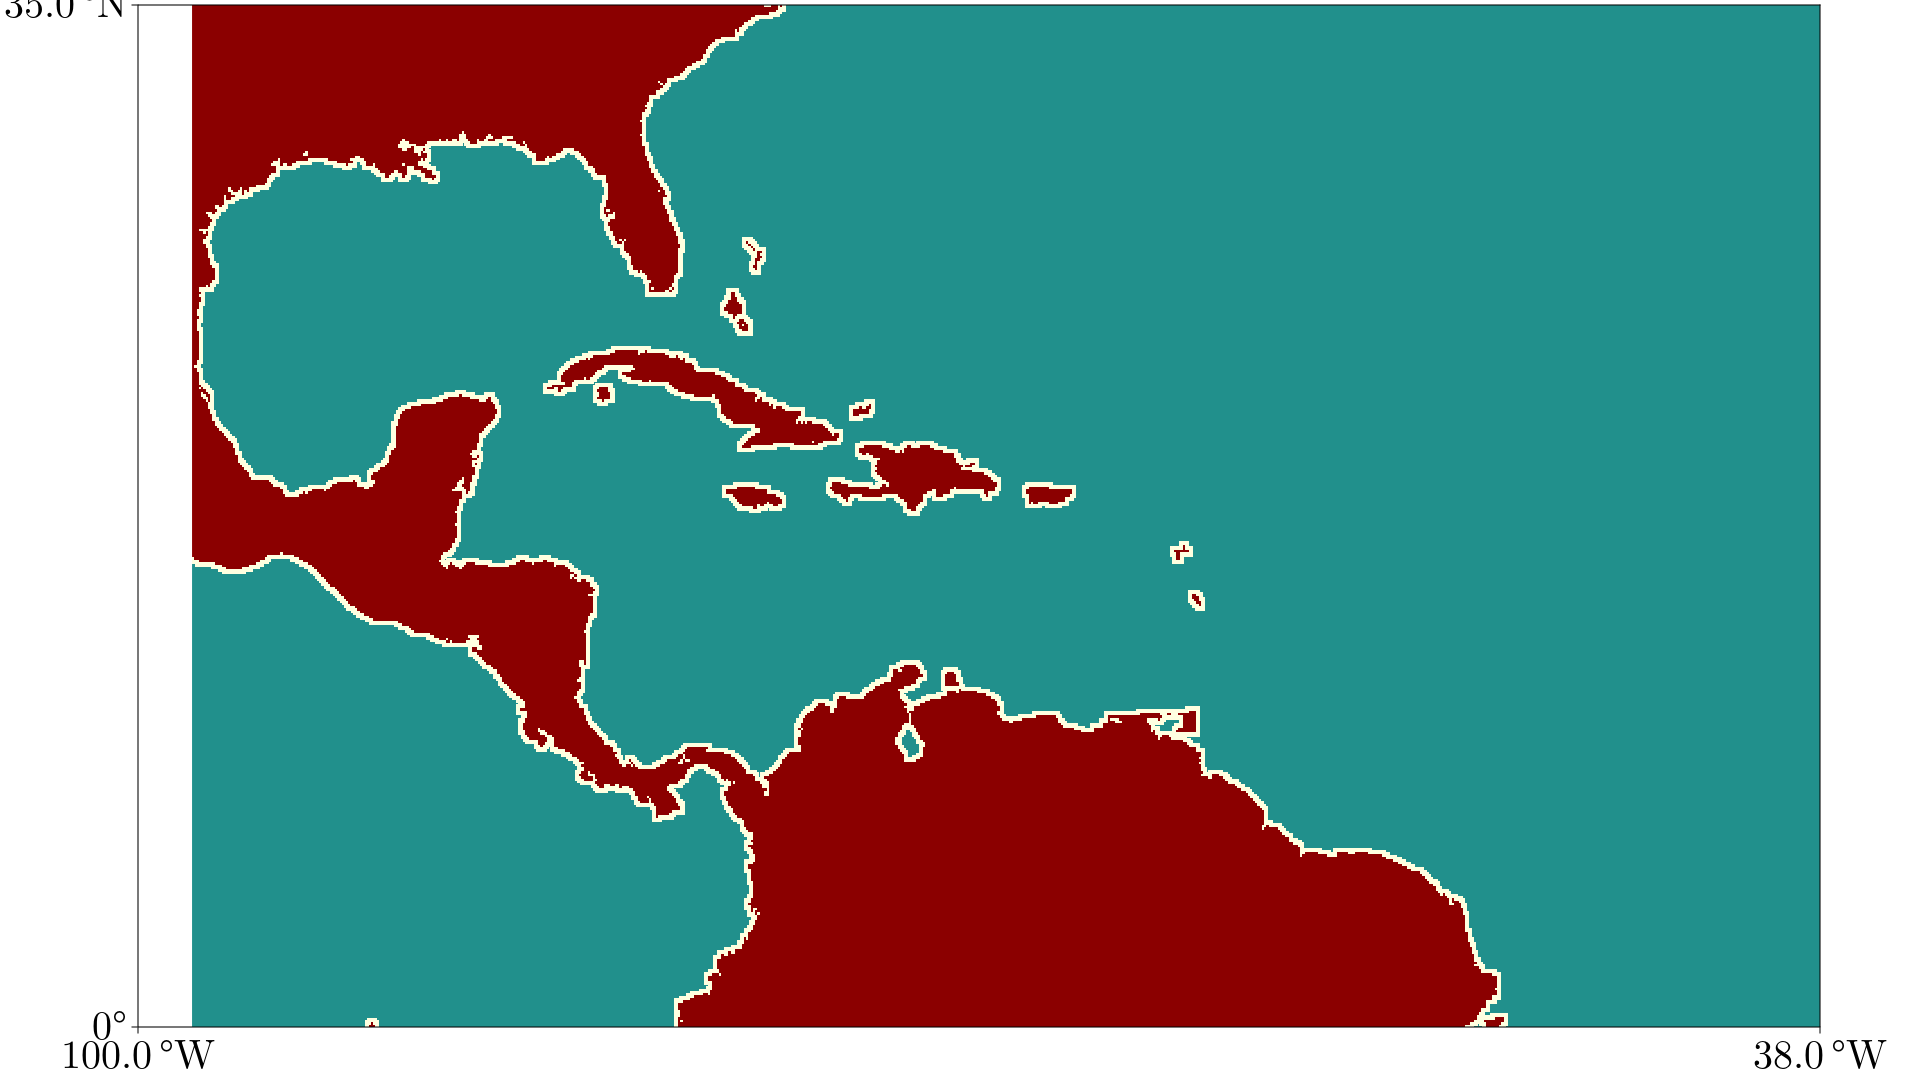

In [10]:
fig = default_fig()

ax = geo_axis(fig[1, 1], title = "", limits = (-100, -38, 0, 35))

heatmap!(ax, lon, lat, landseamask_gridded, interpolate = false, colormap = :heat)
heatmap!(ax, lon, lat, landseamask_gridded_coast, interpolate = false)

fig

In [11]:
afai_no_mask = deepcopy(afai)
afai = zeros(eltype(afai_no_mask), size(afai_no_mask))
for t_i = 1:length(time)
    afai[:,:,t_i] = afai_no_mask[:,:,t_i] .* landseamask_gridded_coast
end

### Initial Plots

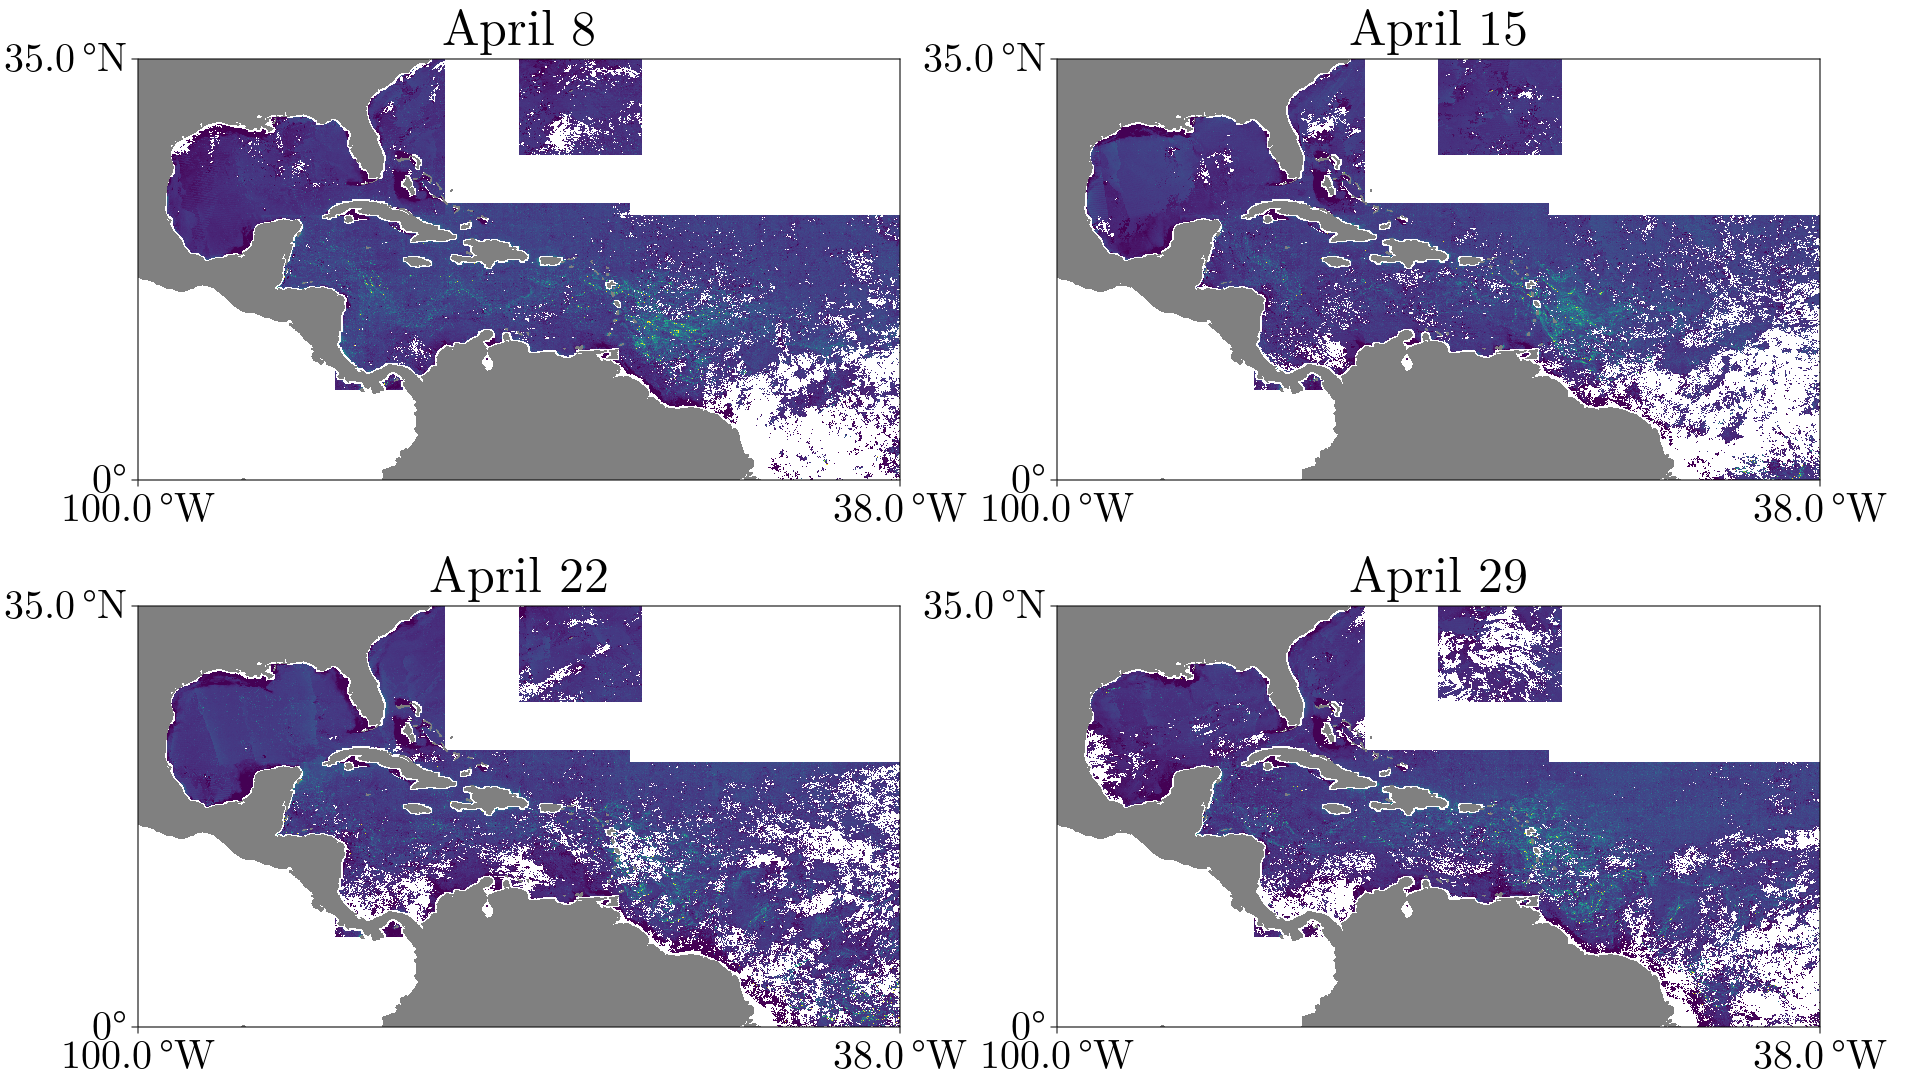

In [12]:
fig = default_fig()

# Day 8
ax = geo_axis(fig[1, 1], title = L"\text{April 8}", limits = (-100, -38, 0, 35))
heatmap!(ax, lon, lat, afai[:,:,1])
land!(ax)

# Day 15
ax = geo_axis(fig[1, 2], title = L"\text{April 15}", limits = (-100, -38, 0, 35))
heatmap!(ax, lon, lat, afai[:,:,2])
land!(ax)

# Day 22
ax = geo_axis(fig[2, 1], title = L"\text{April 22}", limits = (-100, -38, 0, 35))
heatmap!(ax, lon, lat, afai[:,:,3])
land!(ax)

# Day 29
ax = geo_axis(fig[2, 2], title = L"\text{April 29}", limits = (-100, -38, 0, 35))
heatmap!(ax, lon, lat, afai[:,:,4])
land!(ax)

fig

## Step 1: Pixel Classification

### Median Filtering

The following procedure is conducted for each time slice.

We create a new data set `afai_median` such that each point in the lon-lat grid has a value equal to the median `afai` value of the surrounding `51 x 51` point window. `NaN`s are not included in the median calculation, i.e. if a pixel is surrounded by some `NaN`s and some values, the median will be taken over the only the values. If the pixel is surrounded by only `NaN`s, then its value is `NaN`.

In [13]:
# lengthy calculation (~12 mins)
afai_median = zeros(Float32, size(afai))
window_size = 50

for t_i = 1:size(afai_median, 3)
    for lon_i = 1:size(afai_median, 1)
        for lat_i = 1:size(afai_median, 2)
            lons = max(1, lon_i - round(Integer, window_size/2)):min(length(lon), lon_i + round(Integer, window_size/2))
            lats = max(1, lat_i - round(Integer, window_size/2)):min(length(lat), lat_i + round(Integer, window_size/2))
            vaid_pixels = [x for x in afai[lons, lats, t_i] if !isnan(x)]

            if length(vaid_pixels) > 0
                afai_median[lon_i, lat_i, t_i] = median(vaid_pixels)
            else
                afai_median[lon_i, lat_i, t_i] = NaN
            end
        end
    end
end

In [14]:
afai_no_background = afai - afai_median;

### Global Thresholding

The data are thresholded using `T0 = 1.79e-4`, such that all pixels with `afai_no_background > T0` are considered Sargassum-containing.

In [15]:
T0 = 1.79e-4
Tmax = maximum(filter(x -> !isnan(x), afai_no_background))
length(filter(x -> x > T0, afai_no_background))/length(afai_no_background) # percentage of pixels containing Sargassum

0.05678542874147288

In [16]:
sarg_pixels = findall(x->x>T0, afai_no_background);

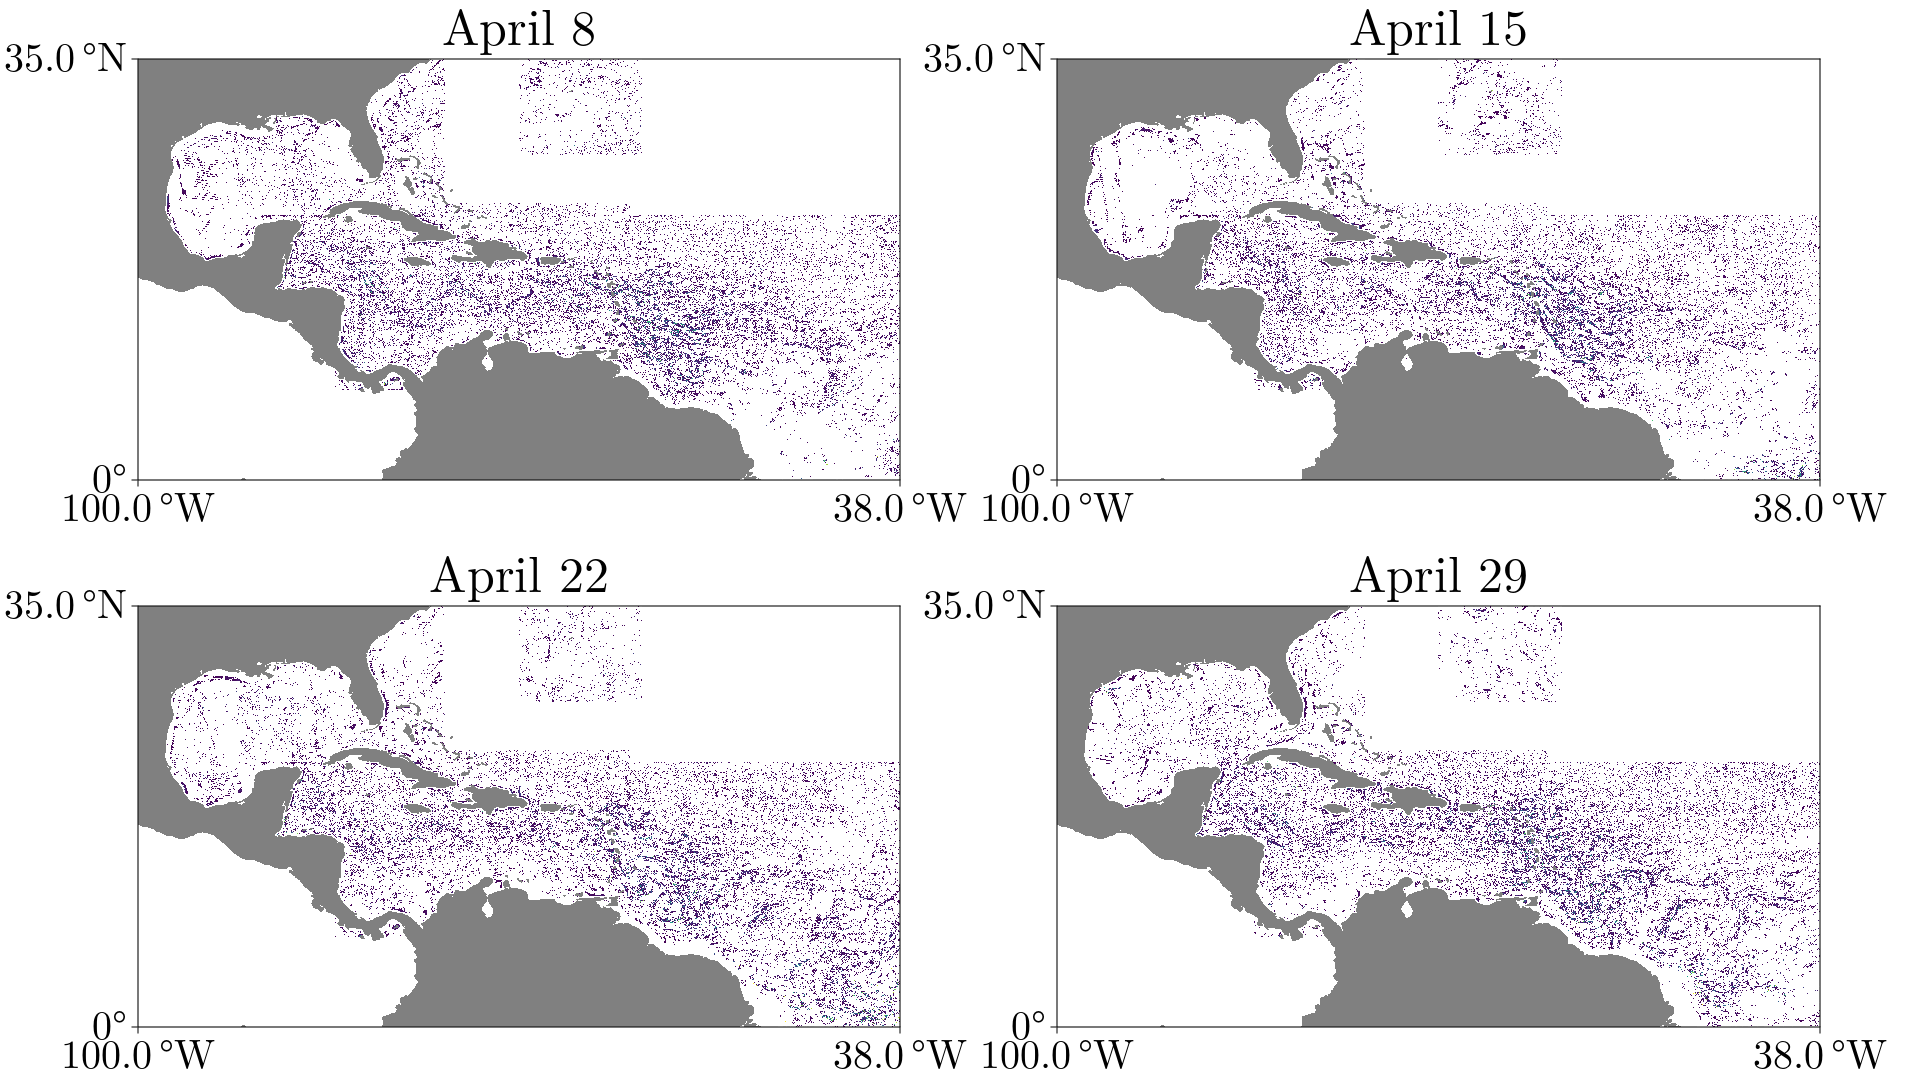

In [17]:
fig = default_fig()

# Day 8
ax = geo_axis(fig[1, 1], title = L"\text{April 8}", limits = (-100, -38, 0, 35))
heatmap!(ax, lon, lat, afai_no_background[:,:,1], colorrange = (T0, Tmax), lowclip = :white)
land!(ax)

# Day 15
ax = geo_axis(fig[1, 2], title = L"\text{April 15}", limits = (-100, -38, 0, 35))
heatmap!(ax, lon, lat, afai_no_background[:,:,2], colorrange = (T0, Tmax), lowclip = :white)
land!(ax)

# Day 22
ax = geo_axis(fig[2, 1], title = L"\text{April 22}", limits = (-100, -38, 0, 35))
heatmap!(ax, lon, lat, afai_no_background[:,:,3], colorrange = (T0, Tmax), lowclip = :white)
land!(ax)

# Day 29
ax = geo_axis(fig[2, 2], title = L"\text{April 29}", limits = (-100, -38, 0, 35))
heatmap!(ax, lon, lat, afai_no_background[:,:,4], colorrange = (T0, Tmax), lowclip = :white)
land!(ax)

fig

## Step 2: Unmixing of Sargassum Pixels

Now, we need to determine what fraction of each pixel is actually Sargassum. To do this, we first define global upper and lower bounds `afai_U0 = 4.41e-2` and `afai_L0 = -8.77e-4`. Then, the fractional coverage by a Sargassum-containing pixel is given by its `afai` value (not `afai_no_background`!) scaled linearly between these limits. Pixels which do not contain Sargassum have a coverage of `0`.

In [18]:
coverage = zeros(Float32, size(afai))
afai_U0 = 4.41e-2
afai_L0 = -8.77e-4

-0.000877

In [19]:
for pixel_index in sarg_pixels
    alpha = (afai[pixel_index] - afai_L0)/(afai_U0 - afai_L0)
    if alpha > 1
        alpha = 1.0f0
    elseif alpha < 0
        alpha = 0.0f0
    end
    coverage[pixel_index] = alpha
end

## Step 3: Coverage

Now we bin the data

In [20]:
mean_coverage = mean([coverage[:,:,t] for t = 1:size(coverage, 3)]);

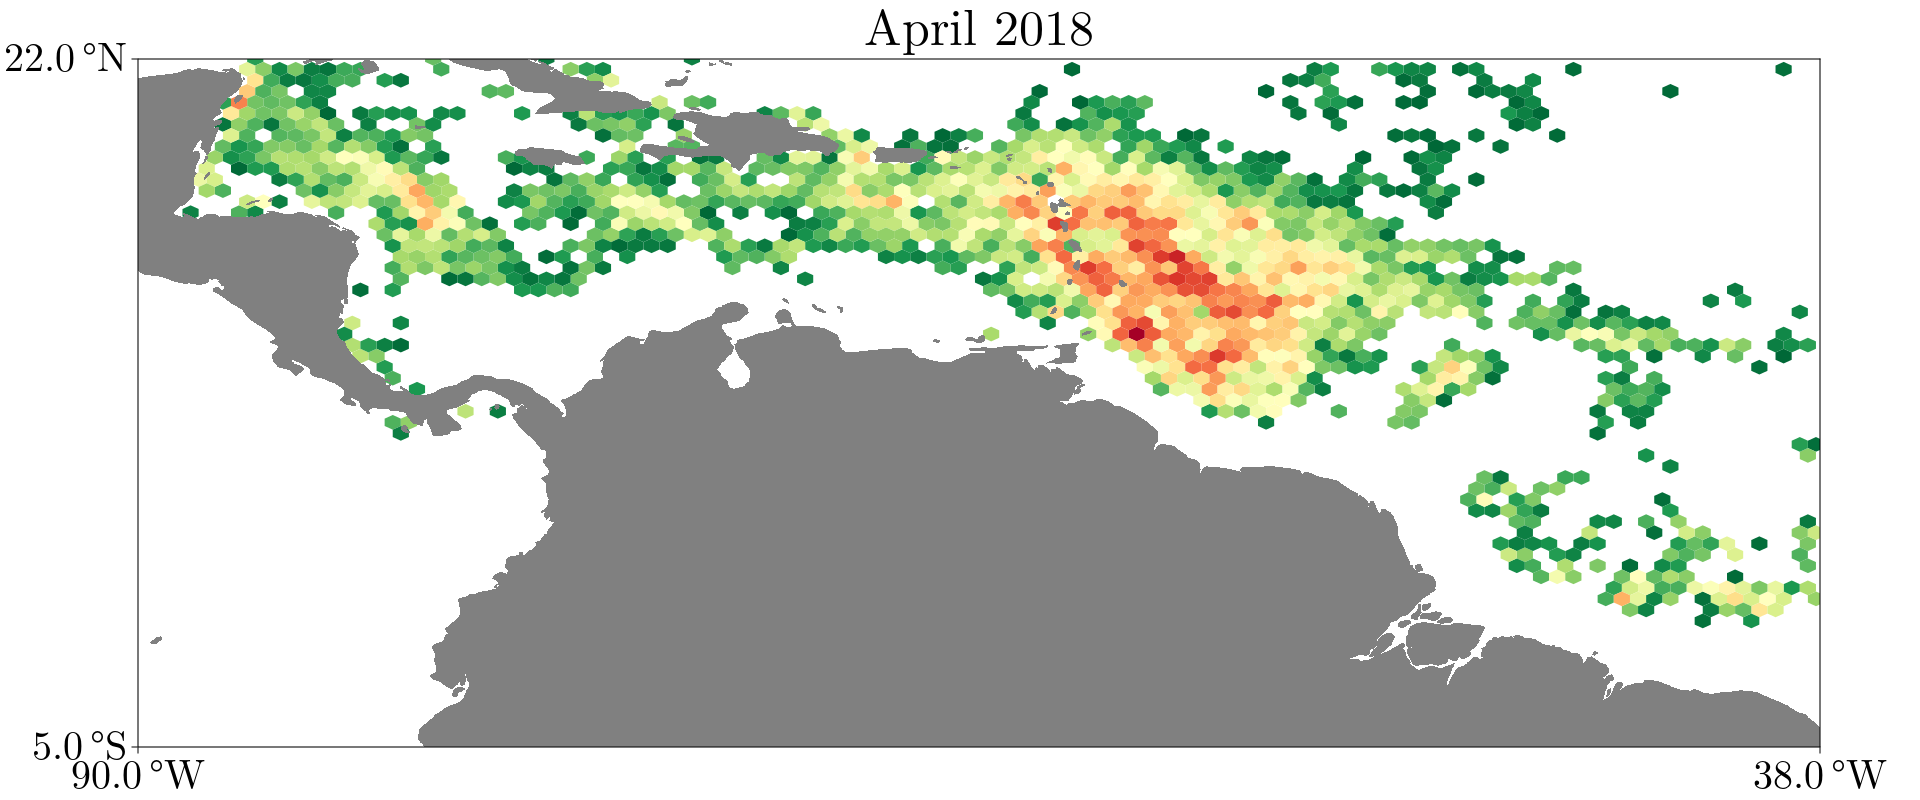

In [21]:
fig = Figure(
    # resolution = (1920, 1080), 
    resolution = (1920, 800),
    fontsize = 50,
    figure_padding = (5, 100, 5, 5))

# Day 8
ax = geo_axis(fig[1, 1], title = L"\text{April 2018}", limits = (-90, -38, -5, 22))
points = vec(Point2f.(lon, lat'))
weights8 = [mean_coverage[x, y] for y = 1:size(mean_coverage, 2) for x = 1:size(mean_coverage, 1)]

hexbin!(ax, points, weights = weights8, cellsize = 0.5, colormap = Reverse("RdYlGn"), colorscale = log10)
land!(ax)

fig

In [22]:
step_lon = 30
step_lat = 40

lon_bins = Iterators.partition(1:length(lon), step_lon) |> collect
lat_bins = Iterators.partition(1:length(lat), step_lat) |> collect

coverage_binned = zeros(Float32, length(lon_bins), length(lat_bins), size(coverage, 3));

In [23]:
for t = 1:size(coverage_binned, 3)
    for i = 1:length(lon_bins)
        for j = 1:length(lat_bins)
            coverage_binned[i, j, t] = mean(coverage[lon_bins[i], lat_bins[j], t])
        end
    end
end

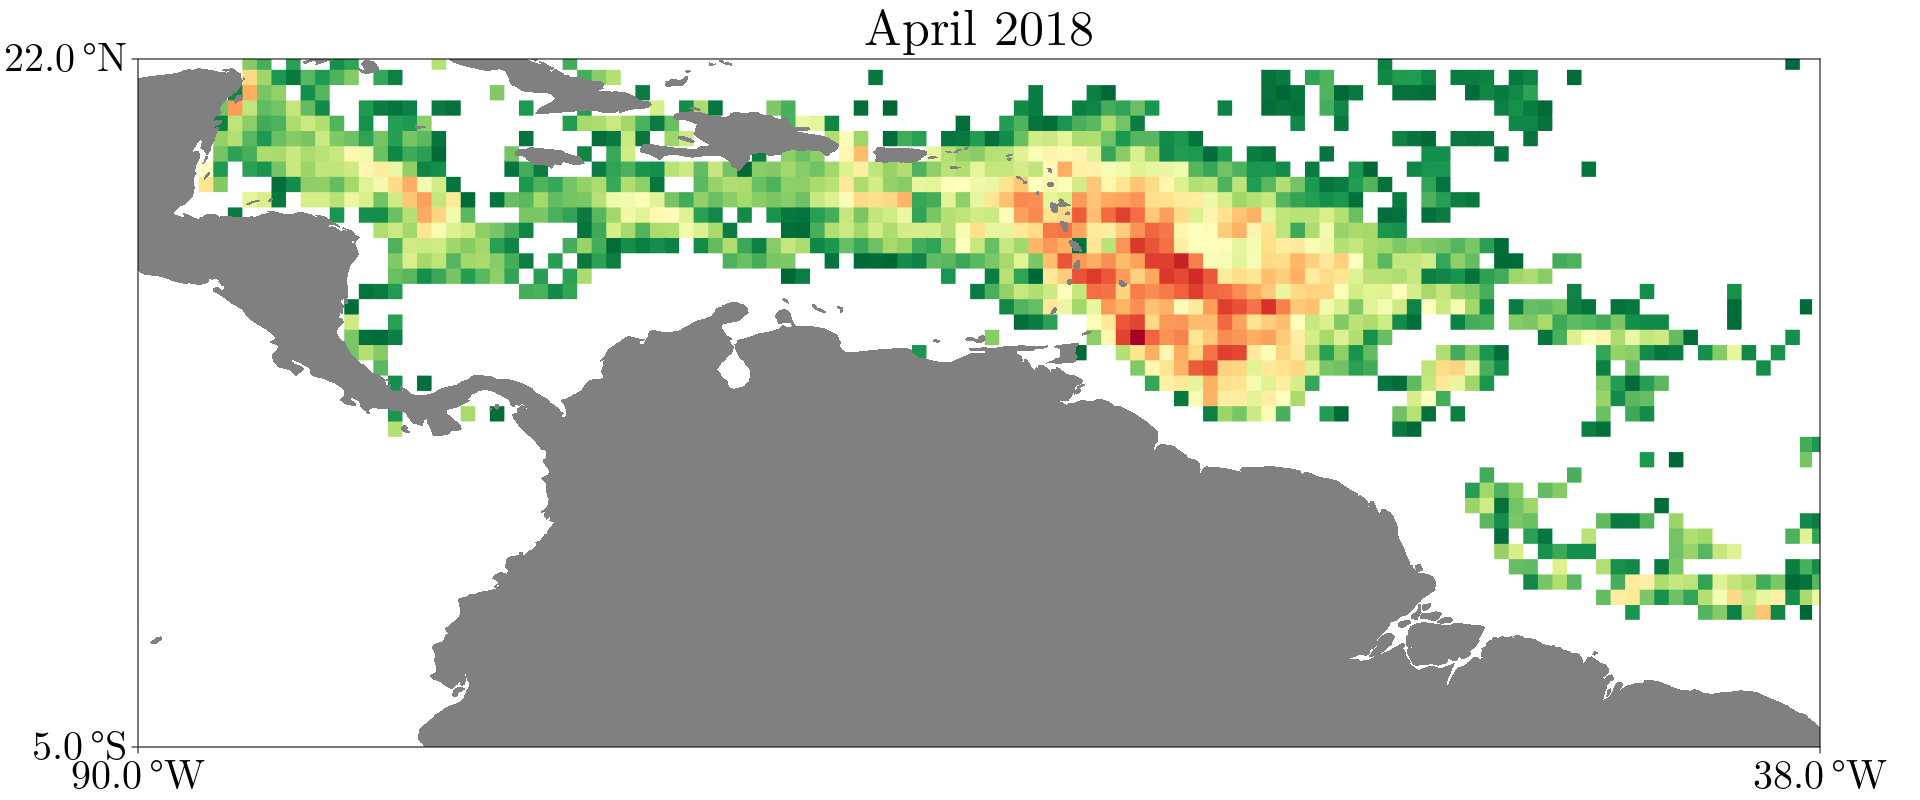

In [24]:
fig = Figure(
    # resolution = (1920, 1080), 
    resolution = (1920, 800),
    fontsize = 50,
    figure_padding = (5, 100, 5, 5))

# Day 8
ax = geo_axis(fig[1, 1], title = L"\text{April 2018}", limits = (-90, -38, -5, 22))

lon_bins_centers = [mean(lon[lon_bin]) for lon_bin in lon_bins]
lat_bins_centers = [mean(lat[lat_bin]) for lat_bin in lat_bins]
coverage_tot = sum(coverage_binned[:,:,t] for t = 1:size(coverage_binned, 3))
# coverage_tot = coverage_binned[:,:,1]
heatmap!(ax, lon_bins_centers, lat_bins_centers, coverage_tot, 
    colormap = Reverse("RdYlGn"),
    colorrange = (38e-4, maximum(coverage_tot)),
    colorscale = log10,
    lowclip = :white)
land!(ax)

fig



fig

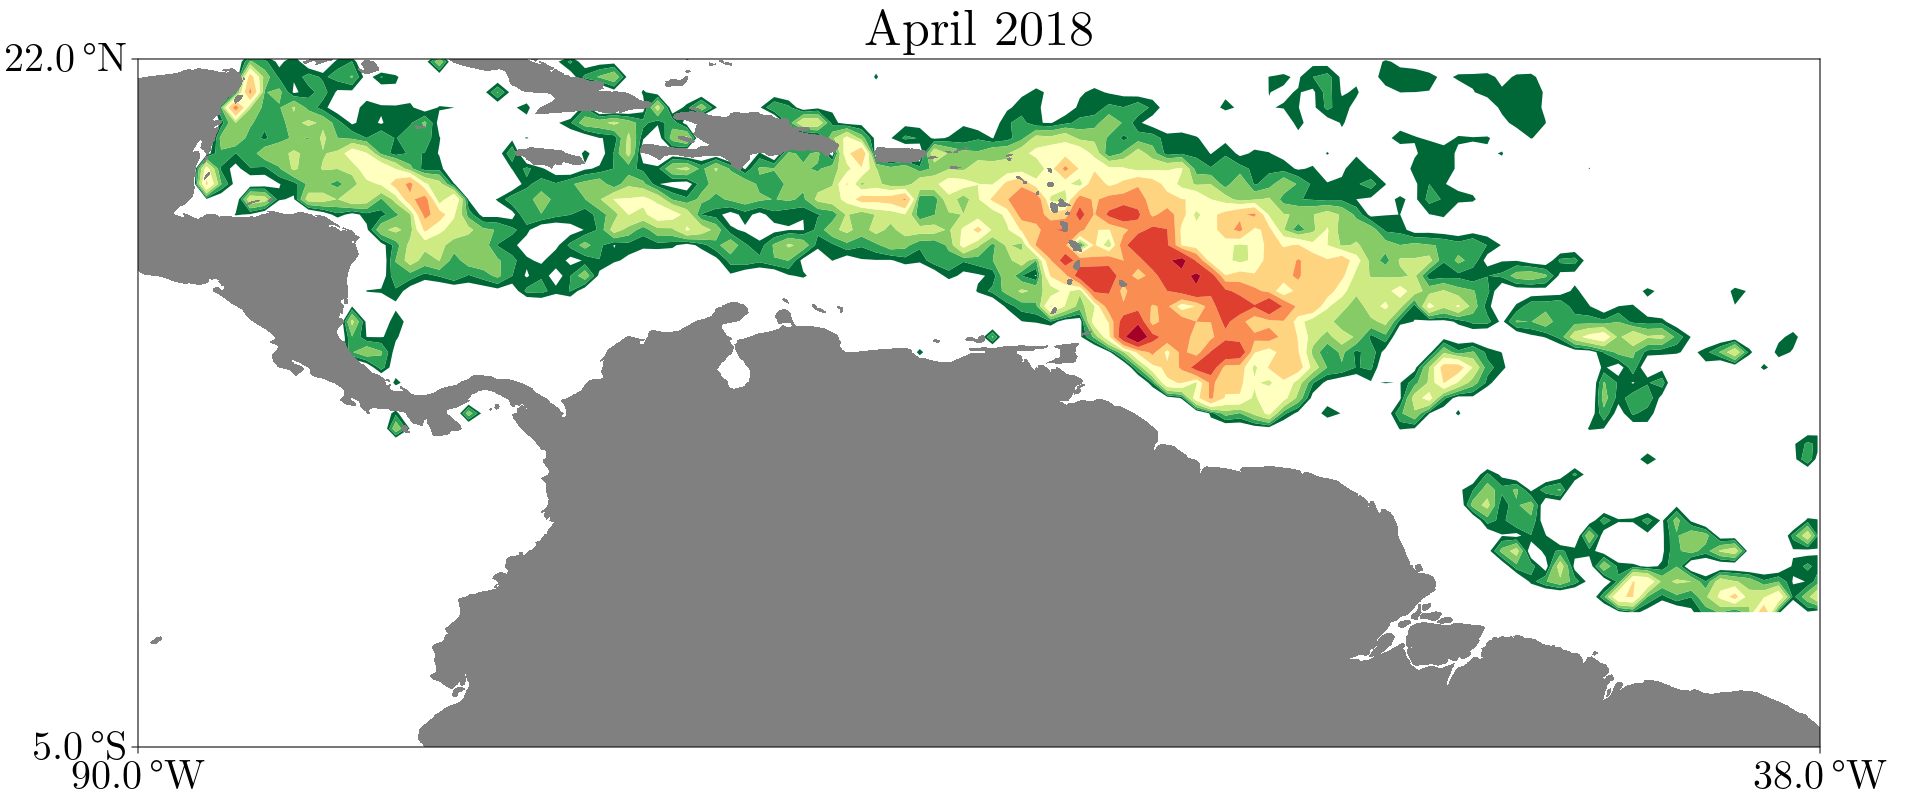

In [25]:
fig = Figure(
    # resolution = (1920, 1080), 
    resolution = (1920, 800),
    fontsize = 50,
    figure_padding = (5, 100, 5, 5))

# Day 8
ax = geo_axis(fig[1, 1], title = L"\text{April 2018}", limits = (-90, -38, -5, 22))

lon_bins_centers = [mean(lon[lon_bin]) for lon_bin in lon_bins]
lat_bins_centers = [mean(lat[lat_bin]) for lat_bin in lat_bins]
coverage_tot = sum(coverage_binned[:,:,t] for t = 1:size(coverage_binned, 3))
# coverage_tot = coverage_binned[:,:,1]
contourf!(ax, lon_bins_centers, lat_bins_centers, coverage_tot, 
    levels = exp10.(range(log10(4e-3), log10(maximum(coverage_tot)), length = 10)),
    colormap = Reverse("RdYlGn"), 
    extendlow = :white)
land!(ax)

fig